In this project we will summarize and compute the principal physical quantities in a synchrotron emission. We will use atropy units module for this purpose and we will base ourselves on NRAO book chapter 5 (https://www.cv.nrao.edu/~sransom/web/Ch5.html) and ThunderBooks basics course (https://github.com/robfender/ThunderBooks/blob/master/Basics.ipynb). A deeper explanation is found on NRAO book chapter 5 (https://www.cv.nrao.edu/~sransom/web/Ch5.html).

## 1. Introducción

In [83]:
import numpy as np
import matplotlib.pyplot as plt

#Packages to make an interactive plot
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widget

#Packages for using tables and units in astropy
from astropy.table import QTable
import astropy.units as u
from astropy.io import ascii

#Astropy module to handle units
from astropy import units as u
from astropy.units import Quantity
from astropy import constants as const

#Importing the constant that will be needed
from astropy.constants import c, k_B,m_e,e

#Packages to make an interactive plot
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widget

Now we define a set of functions that will be used along the project, first one will give the size of an expanding object

In [84]:
def sizefromt(t,v):
    """
    sizefromt gives the radius (meter) and volume (meter^3) that a object starting as a point and expanding a time t
    with constant speed v will have. If units are desired at the output, they must be inserted in the parameters with unit
    module

    Parameters
    :t: Time of the evolution
    :v: Speed at which the object is expanding

    Output
    :r: Radius of the object at t
    :V: Volume of the object at t
    """
    #Checking that input has units equivalent to the right ones
    t=t.to(u.s)
    v=v.to(u.m/u.s)
    
    #Applying simple trigonometrical expressions
    r=t*v
    V=((4.0/3.0)*np.pi*(r**3.0)) 

    return (r,V)

We will be using solid angles in different expression so it is convenient to make a function on order to get it from the source size and distance.

In [85]:
def solidangle(r,d):
    """
    solidangle gives the solid angle of a source at distance d and size r in the small angle approximation.If units are 
    desired at the output, they must be inserted in the parameters with unit module

    Parameters
    :r: size of the source
    :d: distance from Earth to source

    Outputs
    :omega: solid angle of the source
    """
    #Applying the expresion for the solid angle in the small angle approximation
    omega= np.pi * (r**2)/(d**2)
    return omega*u.sr

In [86]:
def LogLogPlot(x, y, xlabel, ylabel):
    """
    LogLogplot plots a graphic of a given set of points (x,y) with specific y and x labels

    Parameters
    :x: x values of the set of points
    :y: y values of the set of points
    :xlabel: Label for the x axis
    :ylabel: label for the y axis
    """
    #Plotting the points
    plt.plot(x,y)
    #Making the labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

## 2. Basic Calculus.

### 2.1 Frequencies, energy and gamma relation.

A relativistic electron on a magnetic frield radiates energy (synchrotron) peaked at a frequency $\nu_c$ wich can be related to the energy radiated by a non relativistic electron a a magnetic field (cyclotron) peaked at a frequency $\nu_g$ with the expression
$$
    \nu_c=\frac{\gamma^2eB}{2\pi m_e c}.
$$

In the practice, when we make an observation, we measure the frequancy at wich we see the peak, and with that we want to infer the characteristics of the electron and the medium. The peak in frequency observed will be related with electrons with a $\gamma$ given by the following expression
$$
    \gamma= \sqrt{\frac{2\pi m_e \nu_c}{eB}}. 
$$
(EXPRESION NO CONCUERDA 5.81 NRAO CON THUNDERBOOK Y LA DE NRAO NO TIENE SENTIDO UNIDADES)

A simple code can be done in order to get this $\gamma$ factor in function of the observed peak frequency.

In [87]:
def gamma(v, B):
    """
    gamma receives the frequency at wich we are observing the peak of emission and the magnetic field associated with the 
    synchrotron emission and returns the gamma factor associated with the electrons producing the radiation

    Parameters
    :v: frequency at with we observe the peak
    :B: modulus of the amgnetic field at the synchrotron region

    Outputs
    :gamma: gamma factor asociated with the relativistic electrons
    """
    #Converting parameters to SI so it is also checked that they are in units equivalent to Hz and Tesla
    v= v.to(u.Hz)
    B = B.to(u.Tesla)
    
    #Computing the gamma using the constant with respective units
    gamma= (2*np.pi*const.m_e*v/(const.e.si*B))**0.5

    #Output the value with reduced units
    return gamma

In [88]:
def egammaenergy(gamma):
    """
    egammaenergy gives the energy (in MeV) of an electron given its gamma factor

    Parameters
    :gamma: gamma factor of the electron

    Output
    :energy: Relativistic energy of the electron in MeV
    """

    #Computing and output the energy with units
    energy= const.m_e*gamma*const.c**2
    return energy.to(u.MeV)

### 2.2 Brightness temperature.

Brightness temperature of an object is defined as the temperature that a black body with the same size will need in order to produce the same flux at that frequency. It is a very usefull maximum, synchrotron maximun emission is around $10^{12} K$ so temepratures above this are either due bad assumption, doppler boost or coherent emission. Brightness temperature can be written as
$$
    T_B= \frac{S_\nu c^2}{2 K_B \Omega \nu^2}
$$

In [89]:
def TB(S, R, d, v):
    """
    TB gives the brightness temperature for a given flux, radius and frequency. It assumes small angle approximation and 
    circular shape of the source

    Parameters
    :S: flux of the source
    :R: radius of the source
    :d: distance from earth to source 
    :v: frequency at wich we want to calculate the brightness temperature

    Output
    :TB: brightness temperature 
    """

    #Makign sure every input is on a unit equivalent to a valid one
    S=S.to(u.Jy)
    R= R.to(u.m)
    d= d.to(u.m)
    v= v.to(u.Hz)

    #Computing the brightness temperature
    TB= S*const.c**2/(2*const.k_B*solidangle(R,d)*v**2)
    return TB.to(u.K)

When we do not have a resolved source we can constrain the size of the source by variability timescale and get a lower limit for the brightness temperature.

In [90]:
def TBfromt(S, t, d, v):
    """
    TBfromt gives a lower limit for brightness temperature for a given flux, frequency and variability timescale. 
    It assumes small angle approximation and circular shape of the source

    Parameters
    :S: flux of the source
    :t: variability timescale
    :d: distance from earth to source 
    :v: frequency at wich we want to calculate the brightness temperature

    Output
    :TB: brightness temperature lower limit
    """

    #Making sure every input is on a unit equivalent to a valid one
    S= S.to(u.Jy)
    t= t.to(u.s)
    d= d.to(u.m)
    v= v.to(u.Hz)

    #Getting the radius from variability timescale
    R=sizefromt(t,const.c)[0]
    
    #Computing the brightness temperature
    TB= S*const.c**2/(2*const.k_B*solidangle(R,d).value*v**2)
    return TB.to(u.K)

## 3. Minimun Energy.

It can be shown (NRAO Chapter 5) that a synchrotron source energies stored in electrons and magentic field are proportional to the magnetic field as
$$
    U_e \propto B^{-3/2} ~~~~~~ U_B \propto B^2.
$$

We can assume that the total energy is only given by cosmic rays and magnetic fields, i.e, $U=(1+\beta)U_e+U_B$, where $\beta$ is the ion-electron energy ratio. Under this asumption, the minimun of the energy in function of B can be found and relates the energies as
$$
    (1+\beta)U_e= \frac{3}{4} E_e.
$$
since they both are so symillar this is the so called equipartition principle.

### 3.1 simple model for showing equipartition.

Longair made a simplified formula for medium with spectral index $\alpha=0.75$ with 
$$
    E_{min,SI} \approx 3\cdot 10^6 \eta^{4 / 7} V^{3 / 7} \nu^{2 / 7} L^{4 / 7}~~J,
$$
where V is the emitting volume, $\nu$ is the observed frequency, $L$ is the specific luminosity and every magnitude is on the international system. The magnetic field at this minimun energy is given by
$$
    B_{\operatorname{minE}, \mathrm{SI}}=1.8\left(\frac{\eta L_\nu}{V}\right)^{2 / 7} \nu^{1 / 7}~~T,
$$
where $\eta=1+\beta$.

In [91]:
def Lum(S,d):
    """
    Lum calculates the luminosity of an object with a given observed flux density and it's distance from Earth

    Parameters
    :S: object observed flux density
    :d: object distance from Earth

    Output
    :Lum: luminosity of the object
    """

    #Checking units
    S= S.to(u.Jy)
    d= d.to(u.m)

    #Computing the luminosity
    L= 4*np.pi*d**2*S
    return L

In [92]:
def LongairMinE(eta, V, v, L):
    """
    LongairMinE gives the minimun energy given a electron-proton energy ratio, a volume of emission, frequency of the 
    observed radiation and luminosity observed.

    Parameters
    :eta: fraction of energy carried by electron and ions
    :V: total volume of emission
    :v: frequency of observed radiation
    :L: luminosity of the object

    Output
    :Emin: minimun energy of the system
    """

    #Check that every input is on the right magnitudes
    eta= eta*u.dimensionless_unscaled
    V= V.to(u.m**3)
    v= v.to(u.Hz)
    L= L.to(u.W/u.Hz)

    #Computing the minimun energy and putting it in J as the expression indicates
    Emin= (3*10**6*eta**(4/7)*V**(3/7)*v**(2/7)*L**(4/7))
    return Emin.value*u.J

In [93]:
def LongairBminE(eta, V, v, L):
    """
    BminE gives the value of the magnetic field at the minumun energy

    Parameters
    :eta: fraction of energy carried by electron and ions
    :V: total volume of emission
    :v: frequency of observed radiation
    :L: luminosity of the object
    
    Outputs
    :BminE: value of the magnetic field at the energy minimun
    """
    #Checking units
    eta= eta*u.dimensionless_unscaled
    V= V.to(u.m**3)
    v= v.to(u.Hz)
    L= L.to(u.W/u.Hz)
    
    BminE= 1.8*(eta*L/V)**(2/7)*v**(1/7)
    return BminE.value*u.Tesla

Let's plot the energies and see the equipartition principle. By the above expressions we know the value of magnetic field that minimices energy, and by the bove relation how the energy contained in electrons and magnetic field varies with the magnetic field, so assuming equipartition at the minimun, we can get the enery of each field at every B other than the B that minimices energy.

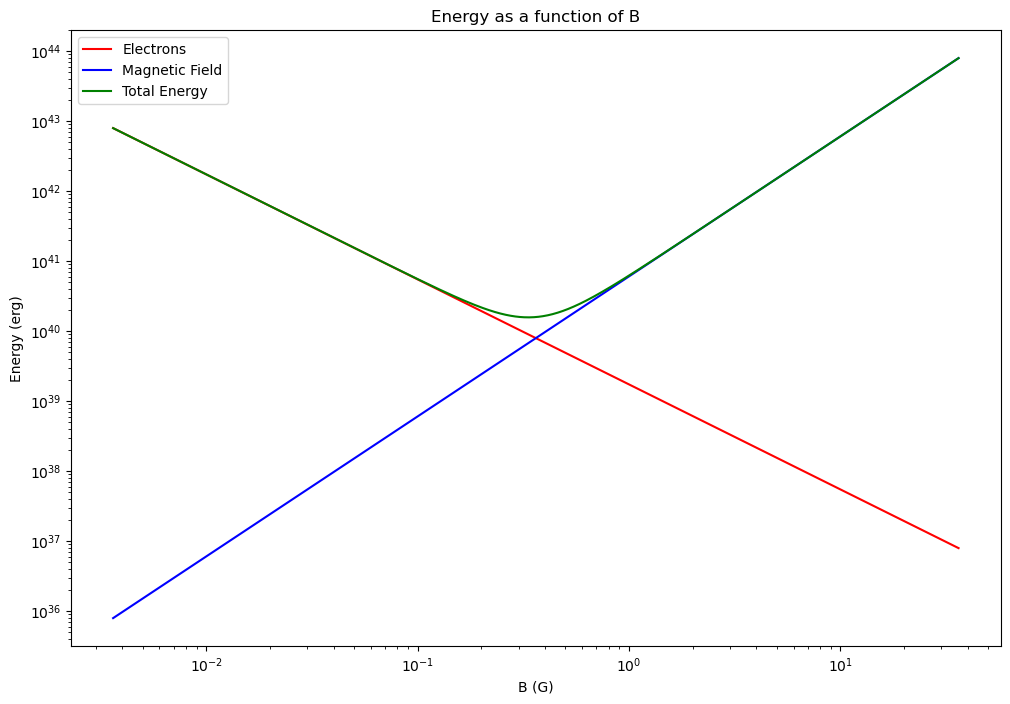

In [94]:
#x will be a set of values of he magnetic field that minimices energy, volume is calculated y timescale
BminE= LongairBminE(1, sizefromt(1800*u.s,const.c)[1] , 1100*u.Hz, Lum(50*u.Jy,11000*u.pc))
BminE= BminE.to(u.Gauss)
x=np.linspace(BminE/100,BminE*100,10000)

#Defining the energy of the electrons and the energy of the magnetic field, according to previus expressions
minE= LongairMinE(1, sizefromt(1800*u.s,const.c)[1] , 1100*u.Hz, Lum(50*u.Jy,11000*u.pc))
minE= minE.to(u.erg)
#Assuming equipartition, both fields have same energy at the minumun, and know how they vary with B
Ee= minE*(x/BminE)**(-1.5)
Eb= minE*(x/BminE)**(2.)
Etot= Ee +Eb

#Plotting the result and see how the energy behaves with B variations around the B that minimices energy
plt.figure(figsize=(12,8))
plt.yscale('log')
plt.xscale('log')
plt.plot(x,Ee,'r',label="Electrons")
plt.plot(x,Eb,'b',label="Magnetic Field")
plt.plot(x,Etot,'g', label="Total Energy")
plt.xlabel(f'B ({BminE.unit})')
plt.ylabel(f'Energy ({Etot.unit})')
plt.title('Energy as a function of B')
plt.legend()

### 3.2 Synchrotron emission from a power law electron distribution.

Most common observed synchrotron emission comes from a population of electron described by a power law
$$
    N(E)dE = N_0E^{-p}dE,
$$
with $N(E)$ the electron density. There is some comments about the spectrum that can be made

   1. The self absorved part (optically thick) does not have an spectral index $\alpha$ of 2.5 as expected, but of 2.0 because the ffective temperature of the population goes as $T_{eff}\propto \nu^{1/2}$.
   2. In the optically thin region, one can calculate the spectral index directly from $p=1-2\alpha$ (without radiation cooling).

Spectral index is calculated as 
$$
    \alpha=\frac{\log \left(\frac{S_{\nu_1}}{S_{\nu_2}}\right)}{\log \left(\frac{\nu_1}{\nu_2}\right)} ~~~~ \Longrightarrow ~~~~ S_\nu \propto \nu^\alpha
$$

In order to get a set of expressions for the spectrum of a electron population driven by a power law we will need to consider a set of constants defined in cgs.

$$
c_1 = 6.27 \cdot 10^{18}
$$

$$
c_5 = (2.26, 1.37, 0.97)\cdot 10^{-23} \text{ for } p = (1.5, 2.0, 2.5)
$$

$$
c_6 = (9.69, 8.61, 8.10)\cdot 10^{-41} \text{ for } p = (1.5, 2.0, 2.5)
$$

And the frequency at which the optical depth is $\tau=1$ can be computed assuming $B\approx Bsin\theta$
$$
    \nu_1=2c_1(sc_6)^{\frac{2}{p+4}}N_0^{\frac{2}{p+4}}B^{\frac{p+2}{p+4}}~~Hz,
$$
where s is the thickness of the source along the line of sight, assumed constant. And the peak occurs at
$$
    \nu_m= \frac{\nu_1}{\tau_m^{\frac{2}{p+4}}},
$$
where $\tau_m=0.35$ for $p=2.$, wich lead to $\nu_m=1.4\nu_1$

It is whown in the bibliografy that the intensity is
$$
    I_\nu = S(\nu_1) J\left( \frac{\nu}{\nu_1},p \right),
$$
where $S(\nu_1)= \frac{c_5}{c_6}B^{-1/2} \left( \frac{\nu_1}{2c_1} \right)^{5/2}$ is the source function at $\nu_1$ and $J(z, p)=z^{\frac{5}{2}}\left[1-\exp \left(-z^{-\frac{p+4}{2}}\right)\right]$. This way the flux is simply
$$
    F_\nu = \Omega I_\nu = \frac{\pi R^2}{D^2}I_\nu.
$$

Let's make a code to calculate the flux. First of all lets compute pacholsky constants and $\nu_1$

In [95]:
#First of all defininf Pacholcyzk's constants
c1=6.27e18

def Pacholcyzk5(p):
    """
    Pacholcyzk5 returns the value of the Pacholcyzk c5 constant given one of th 3 possible values of p
    Parameters
    :p: Coefficient of the power law defining the electron population

    Output
    :c5: Value of the constant
    """
    if p==1.5: return 2.26e-23
    if p==2.0: return  1.37e-23
    if p==2.5: return  0.97e-23
    else: print(f'Not a valid p')

def Pacholcyzk6(p):
    """
    Pacholcyzk6 returns the value of the Pacholcyzk c6 constant given one of th 3 possible values of p
    Parameters
    :p: Coefficient of the power law defining the electron population

    Output
    :c6: Value of the constant
    """
    if p==1.5: return 9.69e-41
    if p==2.0: return  8.61e-41
    if p==2.5: return  8.10e-41
    else: print(f'Not a valid p')

def calculatev1(s, p, N_0, B):
    """
        calculatev1 returns the value of the frequency at which the optical depth is 1 for a population of electron
        driven by a power law

        Parameters
        :s: Thickness of the source
        :p: Exponent of the power law of electron population
        :N_0: Constant multiplicative factor in the power law
        :B: Value of the magnetic field

        Output
        :v1: Frequency at which the optical depth is 1
    """

    #Converting every parameter to cgs and checking they are in the correct units
    s=s.to(u.m).cgs
    p=p*u.dimensionless_unscaled
    N_0=N_0.to(u.erg**p/u.cm**3) #ARE THIS THE RIGHT UNITS?
    B=B.to(u.G)

    #Computing the ressult, and giving it in Hz, since we do not know Pacholcyzk constannt units but we made
    #everything in cgs
    v1=(2*c1*(s*Pacholcyzk6(p))**(2/(p+4))*N_0**(2/(p+4))*B**((p+2)/(p+4))).value*u.dimensionless_unscaled
    return v1*u.Hz

Now let's deffine the functions needed for the intensity.

In [96]:
def Source(p, B, v):
    """
    Source returns the value of the source function for a given frequency

    Parameters
    :p: Exponent of the power law of electron population
    :B: Value of the magnetic field
    :v: frequency at which the source function want to be calculated
    
    Output
    :S: Value of the source function at the given frequency
    """

    #Checking units and putting all in cgs
    p= p*u.dimensionless_unscaled
    B= (B.to(u.G))
    v= (v.to(u.Hz))
    
    S=(Pacholcyzk5(p)/Pacholcyzk6(p)*B**(-1/2)*(v/(2*c1))**(5/2)).value*u.dimensionless_unscaled
    return (S*(u.erg/(u.s*u.cm**2*u.sr*u.Hz)))

def CalculateJ(z, p):
    """
    CalculateJ returns the value of the J function defined on the calculation of the intensity for a population
    of relativistic electrons driven by a power law of exponent p

    Paramenters
    :z: will be the ratio of the frequency of interest and the frequency v1
    :p: Exponent of the power law

    Output
    :J:
    """

    J=z**(5/2)*(1-np.exp(-z**(-(p+4)/2)))
    return J

We can now compute the intensity and the flux.

In [97]:
def SpeInt(v, p, B, s, N0):
    """
    SpecInt returns the specific intensity of a population of relativistic electrons driven by a power law at a given
    frequency

    Paramenters
    :v: frequency at which the specific intensity is computed
    :p: exponent of the power law
    :B: Magnetic field
    :s: Thickness of the source
    :N0: Constant of the power law

    Output
    :I: specific intensity at the given frequency
    """

    #Checking units
    v=v.to(u.Hz)
    p=p*u.dimensionless_unscaled
    B=B.to(u.T)
    s=s.to(u.m)
    N0=N0.to(u.erg**p/u.cm**3)
    
    v1=calculatev1(s, p, N0, B)
    I=Source(p, B, v1)*CalculateJ(v/v1, p)
    return I

def Flux(v, p, B, s, N0, r, D):
    """
    Flux returns the value of the flux foor a population of relativistic electrons driven by a power law at a given frequency

    Parameters
    :v: frequency at which the specific intensity is computed
    :p: exponent of the power law
    :B: Magnetic field
    :s: Thickness of the source
    :N0: Constant of the power law
    :r: radius of the source
    :D: Distance to the source

    Output
    :F: Flux of the source
    """
    #Checking units
    v=v.to(u.Hz)
    p=p*u.dimensionless_unscaled
    B= B.to(u.T)
    s=s.to(u.m)
    N0=N0.to(u.erg**p/u.cm**3)
    r=r.to(u.m)
    D=D.to(u.m)

    F=solidangle(r, D)*SpeInt(v, p, B, s, N0)
    return F.decompose().to(u.Jy)

We can now make a plot and see how this behaves.

Text(0.5, 1.0, 'Flux as function of frequency')

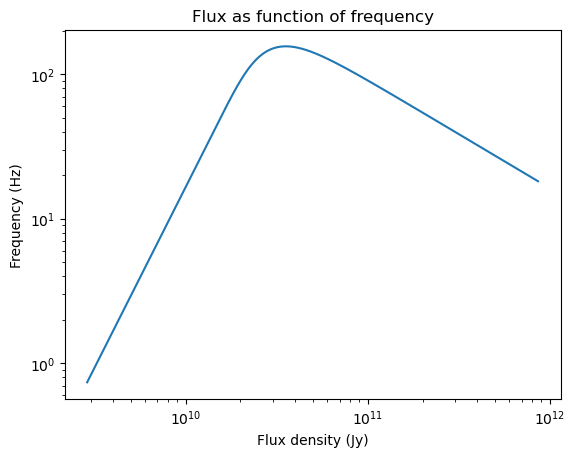

In [98]:
#Putting number on some parameters
B=1.9*u.G
d=3e3*u.pc
p=2.5
#Size of blop from timescale (ussually 1800s for Xray binary)
(r, V) = sizefromt(1800.0*u.s,const.c)
N0=0.0045*u.erg**p/u.cm**3

#Computing the value of v1 and defining points around it
v1 = calculatev1(r, p, N0, B)
x=np.linspace(v1/10.0,v1*30.0,10000)

#Computing the value of the flux in each frequency
F=Flux(x,p, B, r, N0, r, d)

#Plotting the results
plt.plot(x, F)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(f'Flux density ({F.unit})')
plt.ylabel(f'Frequency ({x.unit})')
plt.title('Flux as function of frequency')

### 3.3 Spectrum evolution in an expanding blob

One of the easiest models to study the evolution of an expanding glob was proposed by van der laan, it consider that
$$
    N_0 \propto R^{-(2+p)}~~~~~~~~~~B\propto R^{-2}
$$
We consider what happens when the radius is a factor 2 smaller and a factor 2 larger. If the expansion is linear this implies ($t=1,2,4$)

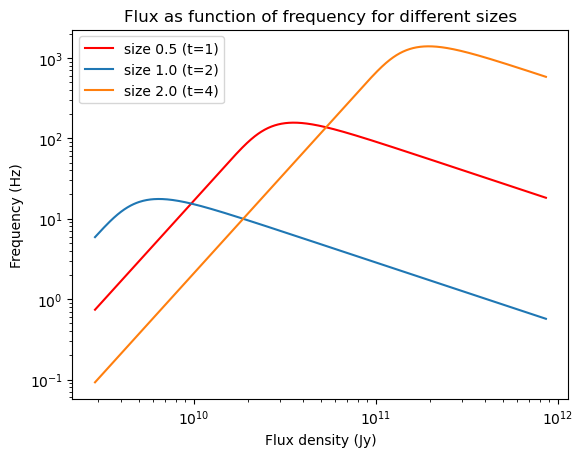

In [99]:
#Calculate the new variables for factor 2
r1=r*2.0
N01=N0*(2.0**(-(2+p)))
B1=B*2**(-2)

#Recalculate flux
F1=Flux(x,p, B1, r1, N01, r1, d)

#Calculate the new variables for factor 0.5
r4=r*0.5
N04=N0*(0.5**(-(2+p)))
B4=B*0.5**(-2)

#Recalculate everything
F4=Flux(x,p, B4, r4, N04, r4, d)

#Plotting results
plt.plot(x, F, 'r',label="size 0.5 (t=1)")
plt.plot(x, F1, label="size 1.0 (t=2)")
plt.plot(x, F4, label="size 2.0 (t=4)")
plt.yscale('log')
plt.xscale('log')
plt.xlabel(f'Flux density ({F.unit})')
plt.ylabel(f'Frequency ({x.unit})')
plt.title('Flux as function of frequency for different sizes')
plt.legend()

We can also check how the flux density evolves with time for a given frequency, in this case we will conider a lineal expansion.

In [100]:
def PLradius(t, v, r0, a):
    """
    PLradius gives the radius after a given t of an expanding object with initial radius and a given speed

    Parameters
    :t: time of the expansion
    :v: speed of the expansion
    :r0: initial radius
    :a: parameter of the power law

    Output
    :r: radius at the end of the expansion
    """
    #Checking units
    r0=r0.to(u.m)
    v=v.to(u.m/u.s)
    t=t.to(u.s)
    
    r=r0 + (v*(t**a)).value*u.m
    return r

def Br(r, B0, r0):
    """
    Br returns the value of the magnetic field at a given r known the value B0 at r0

    Parameters
    :r: radius at which the magnetic field will be calculated
    :B0: magnetic field at a starting radius
    :r0: radius at starting

    Output
    :Br: Magentic field at a radius r of the object
    """

    #Checking units
    r=r.to(u.m)
    B0=B0.to(u.T)
    r0=r0.to(u.m)
    
    Br=B0*((r/r0)**(-2))
    return Br

def Nr(r, N0, r0, p):
    """
    Nr returns the value of the electron density at a given r known the value N0 at r0

    Parameters
    :r: radius at which the magnetic field will be calculated
    :N0: electron density at a starting radius
    :r0: radius at starting
    :p: exponent of the power law

    Output
    :Nr: electron density at a radius r of the object
    """
    #Cheking units
    r=r.to(u.m)
    N0=N0.to(u.erg**p/u.cm**3)
    r0=r0.to(u.m)
    

    Nr=N0*((r/r0)**(-(2+p)))
    return Nr

Let's make a plot of this results

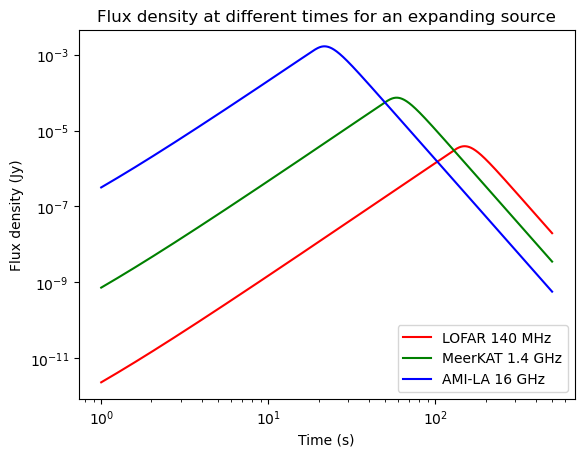

In [103]:
#Quantizing the time
t=np.linspace(1.0, 500.0, 10000)*u.s
#Assuming some input parameters
r0= (10*3.0e6)*100.0*u.cm
d=8000*u.pc
B0= 1.0e3*u.G
N0= 1.0e12*u.erg**p/u.cm**3
#Choose 3 frequencies to plot
n1= 1.4e8*u.Hz #LOFAR
n2= 1.4e9*u.Hz #MeerKat
n3= 16e9*u.Hz #AMI-LA

#Computing the values at r
r=PLradius(t, const.c/(3.0**0.5), r0, 1.0)
omega= solidangle(r, d)
B= Br(r, B0, r0)
N= Nr(r, N0, r0, p)

#Computing the flux at r
F1= Flux(n1, p, B, r, N, r, d)
F2= Flux(n2, p, B, r, N, r, d)
F3= Flux(n3, p, B, r, N, r, d)

#Plotting the results
l1="LOFAR 140 MHz"
l2="MeerKAT 1.4 GHz"
l3="AMI-LA 16 GHz"
plt.xscale('log')
plt.yscale('log')
plt.plot(t,F1,'r', label=l1)
plt.plot(t,F2,'g', label=l2)
plt.plot(t,F3,'b', label=l3)
plt.xlabel(f"Time ({t.unit})")
plt.ylabel(f'Flux density ({F1.unit})')
plt.title('Flux density at different times for an expanding source')
plt.legend()
plt.show()